In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords


import re,string,unicodedata
from keras.preprocessing import text, sequence

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation

import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

### Reading data and visualizing

In [3]:
df = pd.read_json('Sarcasm_Headlines_Dataset.json',lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


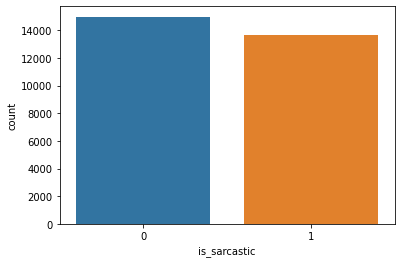

In [4]:

sns.countplot(df.is_sarcastic)
## We can see that the data is balanced

([<matplotlib.patches.Wedge at 0x7fef9b06fe50>,
 [Text(-0.08149207867372818, 1.096977229076992, '0'),
  Text(0.08149207867372756, -1.096977229076992, '1')],
 [Text(-0.044450224731124456, 0.5983512158601773, '52.4%'),
  Text(0.044450224731124116, -0.5983512158601774, '47.6%')])

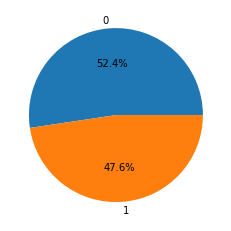

In [5]:
plt.pie(df["is_sarcastic"].value_counts().values,explode=[0,0],labels=df.is_sarcastic.value_counts().index, autopct='%1.1f%%')

In [6]:
del df['article_link'] 

In [7]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [11]:


stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

### CLEANING

In [12]:
#Remove punctiations
def f1(text):
    return re.sub('\[[^]]*\]', '', text)

#Remove sp. char.
def f2(text):
    return re.sub("[^a-zA-Z]"," ",text)

#lemmatization
def f3(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)


#cmbining
def clean(text):
    text = f1(text)
    text = f2(text)
    text = f3(text)
    return text

df['headline']=df['headline'].apply(clean)

In [13]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
from wordcloud import WordCloud

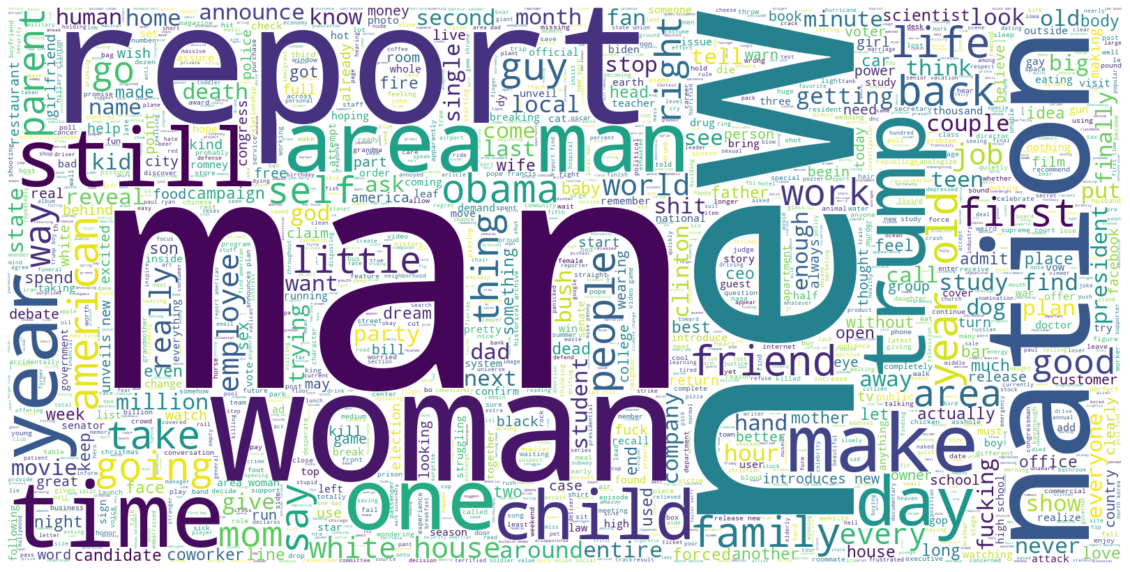

In [15]:
# Wordcloud (for is_sarcastic == 1)

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,background_color="white").generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

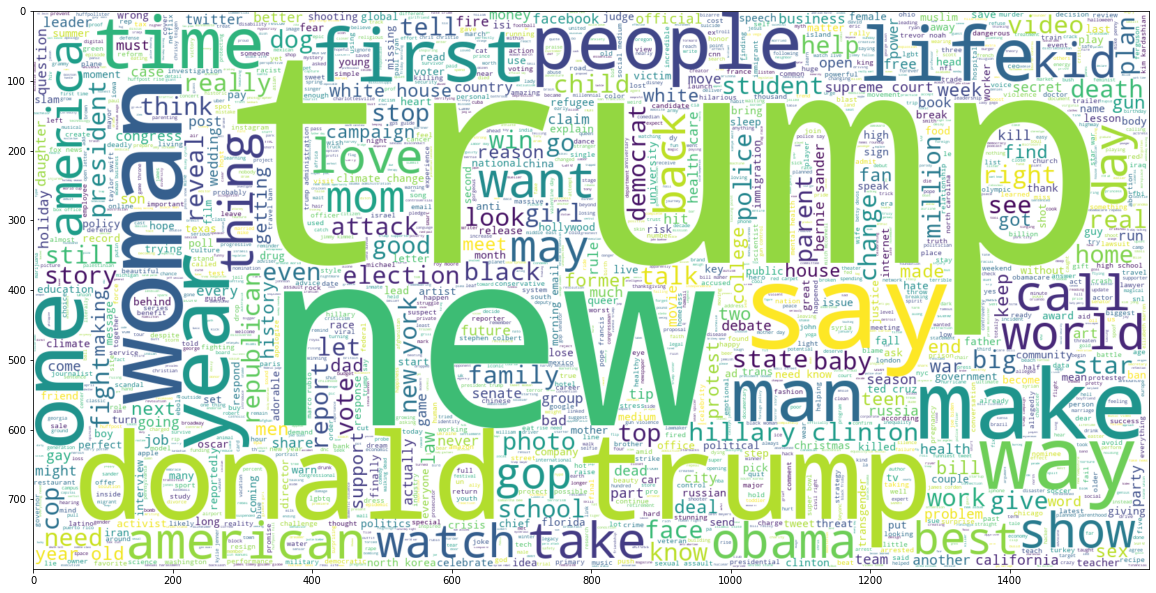

In [16]:
# Wordcloud (for is_sarcastic == 1)

plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,background_color="white").generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

In [17]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic, test_size = 0.3 , random_state = 0)

In [18]:
max_features = 35000
maxlen = 200

## Tokenizing and padding

In [19]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [20]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

### Using Glove Embedding

In [24]:
embeddings_index = {}
#f = EMBEDDING_FILE
with open('glove.6B.100d.txt','r',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
#f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 25670 word vectors.


In [25]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open('glove.6B.100d.txt','r',encoding='utf-8'))

In [26]:
word_index = tokenizer.word_index

In [28]:
embeddings_index.values()

In [ ]:
embeddings_index

In [36]:
list(embeddings_index)[25669]

'zack'

In [37]:
embeddings_index.get('zack')

array([-0.59059 , -0.36201 , -0.035133, -0.59173 , -0.5251  , -0.071991,
       -0.58623 ,  0.60709 , -0.11913 , -0.053682,  0.69495 ],
      dtype=float32)

In [38]:
del embeddings_index['zack']

In [39]:
all_embs = np.vstack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [41]:
embedding_matrix.shape

(19364, 100)

In [42]:
batch_size = 128
epochs = 2
embed_size = embedding_matrix.shape[1]

### Bidirectional LSTM

In [43]:
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

In [44]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = RMSprop(lr=8.74355057651944e-05), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1936400   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 2,171,153
Trainable params: 2,171,153
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 10)

Epoch 1/10
157/157 [==============================] - 476s 3s/step - loss: 0.6734 - acc: 0.5812 - val_loss: 0.6497 - val_acc: 0.6295
Epoch 2/10
157/157 [==============================] - 457s 3s/step - loss: 0.6427 - acc: 0.6301 - val_loss: 0.6231 - val_acc: 0.6542
Epoch 3/10
157/157 [==============================] - 454s 3s/step - loss: 0.6243 - acc: 0.6493 - val_loss: 0.6187 - val_acc: 0.6584
Epoch 4/10
157/157 [==============================] - 452s 3s/step - loss: 0.6120 - acc: 0.6658 - val_loss: 0.5965 - val_acc: 0.6761
Epoch 5/10
157/157 [==============================] - 456s 3s/step - loss: 0.5997 - acc: 0.6755 - val_loss: 0.5702 - val_acc: 0.6996
Epoch 6/10
157/157 [==============================] - 454s 3s/step - loss: 0.5916 - acc: 0.6843 - val_loss: 0.6066 - val_acc: 0.6706
Epoch 7/10
157/157 [==============================] - 451s 3s/step - loss: 0.5818 - acc: 0.6894 - val_loss: 0.5621 - val_acc: 0.7028
Epoch 8/10
157/157 [==============================] - 440s 3s/step - 

In [47]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

269/269 [==============================] - 38s 140ms/step - loss: 0.5412 - acc: 0.7186
Accuracy of the model on Testing Data is -  71.86117172241211


In [48]:
pred = model.predict(X_test)
pred[:5]

array([[0.36713657],
       [0.40361872],
       [0.42772633],
       [0.1663978 ],
       [0.7929931 ]], dtype=float32)

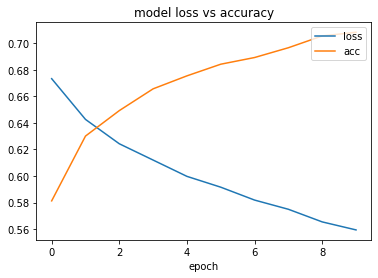

In [53]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['acc'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'acc'], loc='upper right')
pyplot.show() 

### GRU

In [54]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))


model.add(GRU(units=128, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2()))
model.add(GRU(units=64,return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2()))
model.add(GRU(units=32))
#model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = RMSprop(), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          1936400   
                                                                 
 gru (GRU)                   (None, 200, 128)          88320     
                                                                 
 gru_1 (GRU)                 (None, 200, 64)           37248     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,071,409
Trainable params: 2,071,409
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [55]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 5)

Epoch 1/5
157/157 [==============================] - 29s 139ms/step - loss: 0.6460 - acc: 0.6281 - val_loss: 0.6105 - val_acc: 0.6799
Epoch 2/5
157/157 [==============================] - 19s 121ms/step - loss: 0.5929 - acc: 0.6887 - val_loss: 0.5719 - val_acc: 0.7100
Epoch 3/5
157/157 [==============================] - 18s 114ms/step - loss: 0.5627 - acc: 0.7143 - val_loss: 0.5476 - val_acc: 0.7293
Epoch 4/5
157/157 [==============================] - 18s 114ms/step - loss: 0.5416 - acc: 0.7308 - val_loss: 0.5366 - val_acc: 0.7353
Epoch 5/5
157/157 [==============================] - 18s 114ms/step - loss: 0.5235 - acc: 0.7395 - val_loss: 0.5352 - val_acc: 0.7360


In [57]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

269/269 [==============================] - 13s 47ms/step - loss: 0.4736 - acc: 0.7749
Accuracy of the model on Testing Data is -  77.48660445213318


In [59]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 10)

Epoch 1/10
157/157 [==============================] - 19s 123ms/step - loss: 0.4441 - acc: 0.7934 - val_loss: 0.4711 - val_acc: 0.7753
Epoch 2/10
157/157 [==============================] - 18s 116ms/step - loss: 0.4337 - acc: 0.7994 - val_loss: 0.4633 - val_acc: 0.7817
Epoch 3/10
157/157 [==============================] - 19s 122ms/step - loss: 0.4220 - acc: 0.8067 - val_loss: 0.4695 - val_acc: 0.7753
Epoch 4/10
157/157 [==============================] - 19s 122ms/step - loss: 0.4132 - acc: 0.8091 - val_loss: 0.4581 - val_acc: 0.7850
Epoch 5/10
157/157 [==============================] - 19s 122ms/step - loss: 0.4032 - acc: 0.8186 - val_loss: 0.4578 - val_acc: 0.7845
Epoch 6/10
157/157 [==============================] - 18s 114ms/step - loss: 0.3951 - acc: 0.8214 - val_loss: 0.4482 - val_acc: 0.7907
Epoch 7/10
157/157 [==============================] - 18s 114ms/step - loss: 0.3865 - acc: 0.8273 - val_loss: 0.4431 - val_acc: 0.7919
Epoch 8/10
157/157 [==============================] - 1

In [60]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

269/269 [==============================] - 13s 47ms/step - loss: 0.4367 - acc: 0.7947
Accuracy of the model on Testing Data is -  79.46657538414001


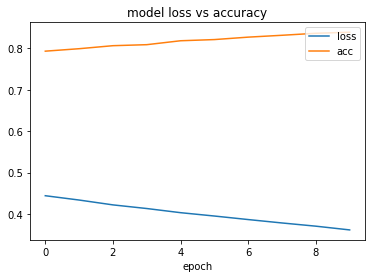

In [61]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['acc'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'acc'], loc='upper right')
pyplot.show()

In [ ]:
#GRU is performing better than Bidirectional LSTM